In [301]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt


def find_high_limit(classical_runtime_func, quantum_runtime_func, initial_high=200):
    low, high = 2, initial_high
    while low < high:
        mid = (low + high) // 2
        try:
            classical_mid = classical_runtime_func((10**mid))
            quantum_mid = quantum_runtime_func(10**mid)
            if classical_mid == np.inf or quantum_mid == np.inf:
                high = mid
            else:
                low = mid + 1
        except (OverflowError, ValueError):
            high = mid
    return 10**(low)

def find_n_star(classical_runtime_func, quantum_runtime_func, initial_range=(2, 1e200)):
    low, high = initial_range


    # Efficiently find the highest value of high that does not cause overflow or is not inf
    high = find_high_limit(classical_runtime_func, quantum_runtime_func, math.log(high,10))

    # Check the boundary conditions
    # classical_low = classical_runtime_func(low)
    # quantum_low = quantum_runtime_func(low)
    # classical_high = classical_runtime_func(high)
    # quantum_high = quantum_runtime_func(high)
    
    # if classical_low > quantum_low and classical_high > quantum_high:
    #     raise ValueError("The classical runtime is slower than the quantum runtime for all values of n.")
    # elif classical_low < quantum_low and classical_high < quantum_high:
    #     raise ValueError("The classical runtime is faster than the quantum runtime for all values of n.")
    
    # Binary search for n*
    while high - low > 0.001*high:
        mid = (low + high) / 2
        classical_mid = classical_runtime_func(mid)
        quantum_mid = quantum_runtime_func(mid)
        
        if classical_mid > quantum_mid:
            high = mid
        else:
            low = mid

    return (low + high) // 2


def find_n_star_by_year(classical_runtime_func, quantum_runtime_func, year, quantum_improvement_rate, initial_range=(2, 1e200)):
    quantum_runtime_func_aux = lambda x: quantum_runtime_func(x) * (1 - quantum_improvement_rate)**(year - 2024)
    return find_n_star(classical_runtime_func, quantum_runtime_func_aux, initial_range=initial_range)


        
def get_qubits(year, roadmap, extrapolation_type='exponential'):
    years = np.array(sorted(roadmap.keys()))
    
    if year in roadmap:
        return roadmap[year]
    
    if year > np.max(years):
        # regression using two last points
        if extrapolation_type == 'linear':
            regression = np.polyfit(years[-2:], [roadmap[yr] for yr in years[-2:]], 1)
            return np.polyval(regression, year)
        else:
            regression = np.polyfit(years[-2:], [math.log10(roadmap[yr]) for yr in years[-2:]], 1)
            return 10 ** np.polyval(regression, year)
    elif year > np.min(years) and year < np.max(years):
        left_year = years[years <= year][-1]
        right_year = years[years >= year][0]
        left_value = roadmap[left_year]
        right_value = roadmap[right_year]
        if extrapolation_type == 'linear':
            regression = np.polyfit([left_year, right_year], [left_value, right_value], 1)
            return np.polyval(regression, year)
        else:
            regression = np.polyfit([left_year, right_year], [math.log10(left_value), math.log10(right_value)], 1)
            return 10 ** np.polyval(regression, year)
    else:
        return 0
    

    
def get_logical_qubits(year, roadmap, extrapolation_type='exponential', physical_to_logical_ratio=1000, physical_to_logical_improvement=0.1):
    physical_qubits = get_qubits(year, roadmap, extrapolation_type)
    logical_qubits = physical_qubits / (physical_to_logical_ratio * (1 - physical_to_logical_improvement)**(year - 2024))
    return logical_qubits


def get_problem_size(year, roadmap, extrapolation_type='exponential', physical_to_logical_ratio=1000, physical_to_logical_improvement=0.1, logical_to_problem_size='2**q'):
    logical_qubits = get_logical_qubits(year, roadmap, extrapolation_type, physical_to_logical_ratio, physical_to_logical_improvement)
    logical_to_problem_size_func = sp.sympify(logical_to_problem_size)
    return logical_to_problem_size_func.subs({'q': logical_qubits})


High limit: 1e+100
n* = 10^9.490429357537026


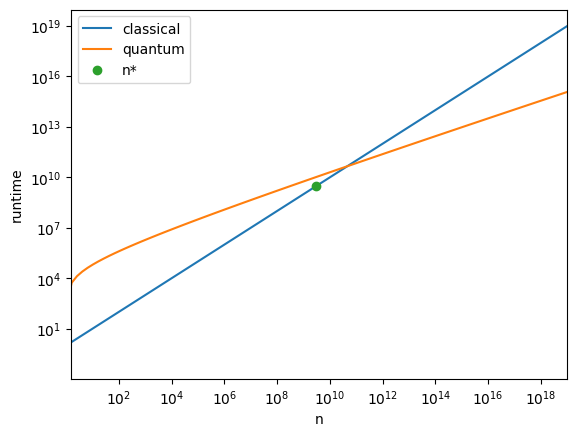

In [285]:
import math

problems = [
    {
        "name": 'Database Search',
        "classical_runtime": 'n',
        "quantum_runtime": 'n**(1/2)'
    },
    {
        "name": 'Integer Factorization',
        "classical_runtime": 'exp((64/9 * n)**(1/3) * log(n)**(2/3))',
        "quantum_runtime": '(n**2) * log(n)'
    },
    {
        "name": 'Traveling Salesman',
        "classical_runtime": '(n**3) * (2**n)',
        "quantum_runtime": 'n * (1.78**n)'
    },
    {
        "name": 'Time Dependent Hartree-Fock Approximation',
        "classical_runtime": 'n**3',
        "quantum_runtime": 'n'
    },
    {
        "name": 'Full Configuration Interaction (Quantum Chemistry)',
        "classical_runtime": 'factorial(n)',
        "quantum_runtime": 'n**11'
    }
]


# for problem in problems:
#     print()
#     print(f"Problem: {problem['name']}")
#     initial_range = (2, 1e50)
#     x = sp.symbols('x')
#     n = sp.symbols('n')
#     classical_runtime_func = sp.lambdify(x,  sp.sympify(sp.sympify(problem['classical_runtime']).subs(n, x)).subs(n, x), 'numpy')
#     quantum_runtime_func = sp.lambdify(x,  sp.sympify(sp.sympify(problem['quantum_runtime']) * hardware_slowdown * quantum_improvement_rate * sp.sympify(penalty)).subs(n, x), 'numpy')
#     if 'factorial' in problem['classical_runtime'] or 'exp' in problem['classical_runtime']:
#         classical_runtime_func_1 = classical_runtime_func
#         classical_runtime_func = lambda x: classical_runtime_func_1(int(x))
#         initial_range = (2, 1e5)


#     if 'factorial' in problem['quantum_runtime'] or 'exp' in problem['quantum_runtime']:
#         quantum_runtime_func_1 = quantum_runtime_func
#         quantum_runtime_func = lambda x: quantum_runtime_func_1(int(x))
#         initial_range = (2, 1e5)
#     n_star = find_n_star(classical_runtime_func, quantum_runtime_func, initial_range=initial_range)
#     print(f"n* = 10^{math.log(n_star, 10)}")
penalty = 'log(n, 2)'
hardware_slowdown = 10**3.78
quantum_improvement_rate = 0.1

#Database search
classical_runtime = 'n'
quantum_runtime = 'n**(1/2)'

x, n = sp.symbols('x n')
classical_runtime_func = sp.lambdify(x,  sp.sympify(sp.sympify(classical_runtime).subs(n, x)).subs(n, x), 'numpy')

quantum_runtime_func = sp.lambdify(x,  sp.sympify(sp.sympify(quantum_runtime) * hardware_slowdown * sp.sympify(penalty)).subs(n, x), 'numpy')

n_star = find_n_star_by_year(classical_runtime_func, quantum_runtime_func, year=2035.66, quantum_improvement_rate=0.1, initial_range=(2, 1e100))
print(f"n* = 10^{math.log(n_star, 10)}")

# plot
import matplotlib.pyplot as plt
import numpy as np

x = np.logspace(np.log10(0.1), np.log10(n_star**2), 100)

plt.plot(x, classical_runtime_func(x), label='classical')
plt.plot(x, quantum_runtime_func(x), label='quantum')
plt.plot(n_star,classical_runtime_func(n_star), 'o', label='n*')

plt.xlim(1.5, n_star**2)
plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.xlabel('n')
plt.ylabel('runtime')


plt.show()



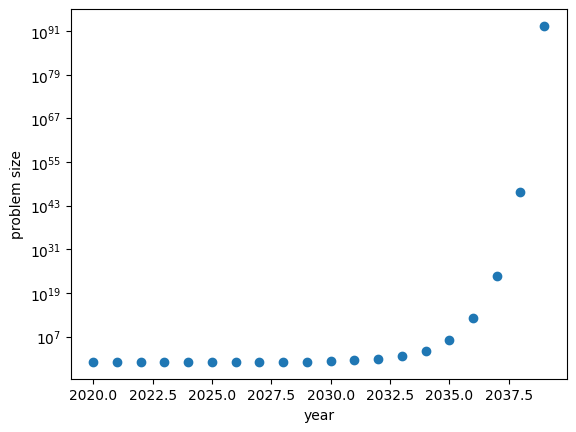

In [302]:
roadmap = {
    2020: 27,
    2022: 127,
    2024: 133,
    2025: 156,
    2029: 200,
    2033: 2000,
}


def get_qubits(year, roadmap, extrapolation_type='exponential'):
    years = np.array(sorted(roadmap.keys()))
    
    if year in roadmap:
        return roadmap[year]
    
    if year > np.max(years):
        # regression using two last points
        if extrapolation_type == 'linear':
            regression = np.polyfit(years[-2:], [roadmap[yr] for yr in years[-2:]], 1)
            return np.polyval(regression, year)
        else:
            regression = np.polyfit(years[-2:], [math.log10(roadmap[yr]) for yr in years[-2:]], 1)
            return 10 ** np.polyval(regression, year)
    elif year > np.min(years) and year < np.max(years):
        left_year = years[years <= year][-1]
        right_year = years[years >= year][0]
        left_value = roadmap[left_year]
        right_value = roadmap[right_year]
        if extrapolation_type == 'linear':
            regression = np.polyfit([left_year, right_year], [left_value, right_value], 1)
            return np.polyval(regression, year)
        else:
            regression = np.polyfit([left_year, right_year], [math.log10(left_value), math.log10(right_value)], 1)
            return 10 ** np.polyval(regression, year)
    else:
        return 0
    

    
def get_logical_qubits(year, roadmap, extrapolation_type='exponential', physical_to_logical_ratio=1000, physical_to_logical_improvement=0.1):
    physical_qubits = get_qubits(year, roadmap, extrapolation_type)
    logical_qubits = physical_qubits / (physical_to_logical_ratio * (1 - physical_to_logical_improvement)**(year - 2024))
    return logical_qubits


def get_problem_size(year, roadmap, extrapolation_type='exponential', physical_to_logical_ratio=1000, physical_to_logical_improvement=0.1, logical_to_problem_size='2**q'):
    logical_qubits = get_logical_qubits(year, roadmap, extrapolation_type, physical_to_logical_ratio, physical_to_logical_improvement)
    logical_to_problem_size_func = sp.sympify(logical_to_problem_size)
    return logical_to_problem_size_func.subs({'q': logical_qubits})
    

# plot problem size vs year
years = np.arange(2020, 2040)
problem_sizes = [get_problem_size(yr, roadmap, extrapolation_type='exponential') for yr in years]
plt.scatter(years, problem_sizes)
plt.xlabel('year')
plt.yscale('log')
plt.ylabel('problem size')
plt.show()



The estimated year when quantum computing will surpass classical computing is 2036.60791015625.
The estimated problem size is 10^18.149549858770843.
[45504995287.0, 69206712174.0, 105123634286.0, 159622242209.0, 242309785265.0, 367721782386.0, 557335517484.0, 844670894374.0, 1279432484395.0, 1936023735378.0, 2929501525418.0, 4431684125799.0, 6698458033400.0, 10127459818911.0, 15291826144404.0, 23082557473831.0, 34844745416685.0, 52566572826410.0, 79291677651490.0, 119585516814654.0, 180261912045734.0, 271531777752549.0, 408907849285441.0, 615953775277838.0, 927151028229992.0, 1395596363062562.0, 2099364002247644.0, 3155643824988825.0, 4746661380717958.0, 7135701170165888.0, 1.0722402674155572e+16, 1.6111252025629916e+16, 2.4199552964549896e+16, 3.632446400536717e+16, 5.455204586026078e+16, 8.183812261380813e+16, 1.2285772215488147e+17, 1.8426647558548832e+17, 2.764399286719003e+17, 4.145392471268472e+17, 6.214067177535939e+17, 9.313862013443715e+17, 1.395631551444519e+18, 2.09183871542

/Users/andrew/.pyenv/versions/3.12.1/envs/venv3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, float)


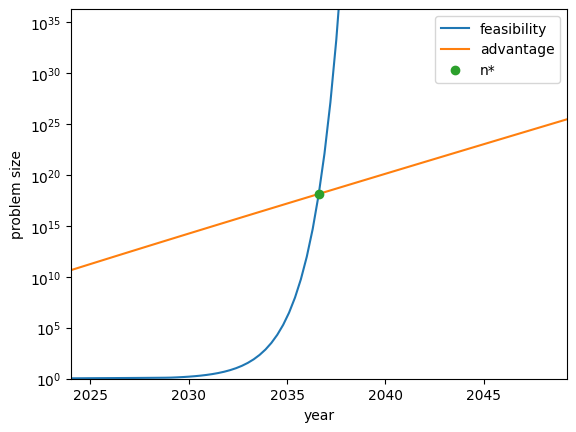

In [330]:
import sympy as sp

def find_n_star_star(classical_runtime_func, quantum_runtime_func, year, roadmap, 
                     extrapolation_type='exponential', physical_to_logical_ratio=1000, 
                     physical_to_logical_improvement=0.1, logical_to_problem_size='2**q',  
                     initial_range=(2, 1e100), quantum_improvement_rate=0.1):


    def get_feasibility(year):
        return get_problem_size(year, roadmap, extrapolation_type, 
                                physical_to_logical_ratio, physical_to_logical_improvement, logical_to_problem_size)

    def get_advantage(year):
        return find_n_star_by_year(classical_runtime_func, quantum_runtime_func, year, quantum_improvement_rate=quantum_improvement_rate, initial_range=initial_range)

    low = 2024
    high = 2100
    epsilon = 0.01

    
    while high - low > epsilon:
        mid = (low + high) / 2
        feasibility = get_feasibility(mid)
        advantage = get_advantage(mid)

        if feasibility > advantage:
            high = mid
        else:
            low = mid

    return mid


estimated_year = find_n_star_star(classical_runtime_func, quantum_runtime_func, year, roadmap,  
                                  extrapolation_type='exponential', physical_to_logical_ratio=1000, 
                                  physical_to_logical_improvement=0.1, logical_to_problem_size='2**q',  
                                  initial_range=(2, 1e100), quantum_improvement_rate=-0.9)

print(f"The estimated year when quantum computing will surpass classical computing is {estimated_year}.")
problem_size = find_n_star_by_year(classical_runtime_func, quantum_runtime_func, estimated_year, quantum_improvement_rate=-0.9, initial_range=(2, 1e100))
print(f"The estimated problem size is 10^{math.log(problem_size, 10)}.")
# plot feasibility/advantage vs year
import matplotlib.pyplot as plt
import numpy as np

years = np.arange(2024, ((estimated_year - 2024) * 2) + 2024, 0.3)
feasibility = [get_problem_size(yr, roadmap, extrapolation_type='exponential') for yr in years]
advantage = [find_n_star_by_year(classical_runtime_func, quantum_runtime_func, yr, quantum_improvement_rate=-0.9, initial_range=(2, 1e100)) for yr in years]
print(advantage)
plt.plot(years, feasibility, label='feasibility')
plt.plot(years, advantage, label='advantage')
plt.plot(estimated_year, problem_size, 'o', label='n*')

plt.xlabel('year')
plt.ylabel('problem size')
plt.yscale('log')
plt.xlim(2024, ((estimated_year - 2024) * 2) + 2024)
plt.ylim(1, problem_size**2)
plt.legend()
plt.show()

In [311]:
math.log10(2318515946.0)

9.365210087178554